<a href="https://colab.research.google.com/github/Akkhar1/Political-Bias-Detection/blob/main/Political_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Buliding the Graph

In [ ]:
!pip install torch_geometric
import kagglehub
import re
import spacy
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch
from torch_geometric.data import Data
from transformers import AutoTokenizer, AutoModel
import random
import pandas as pd
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch.nn.functional as F

In [ ]:
# Set seeds for reproducibility
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
# Download Dataset
dataset_dir = kagglehub.dataset_download("crowdflower/political-social-media-posts")

# Find the CSV file within the directory
for filename in os.listdir(dataset_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(dataset_dir, filename)
        break
else:
    raise FileNotFoundError("No CSV file found in the dataset directory.")

# Read the CSV file, specifying encoding
data = pd.read_csv(file_path, encoding='latin-1')

# Drop missing values in key columns
data.dropna(subset=["text", "bias"], inplace=True)

100%|██████████| 800k/800k [00:00<00:00, 28.4MB/s]

Extracting files...


In [ ]:
# Load Spacy model for NLP processing
nlp = spacy.load("en_core_web_sm")

# Text Cleaning Function
def clean_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])

data["text"] = data["text"].apply(clean_text)

In [ ]:
# Entity Extraction Function
def extract_entities(text):
    doc = nlp(text)
    # Use set to ensure unique entities per article
    return list(set(ent.text for ent in doc.ents)) if doc.ents else []

data["entities"] = data["text"].apply(extract_entities)

In [ ]:
# Encode bias labels
label_encoder = LabelEncoder()
data["bias_label_encoded"] = label_encoder.fit_transform(data["bias"])

# Save label encoder
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

In [ ]:
# Load pre-trained BERT model and tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def get_bert_embeddings_batch(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
            # Use the embedding of the [CLS] token (first token)
            batch_embeddings = outputs.last_hidden_state[:, 0, :]
        embeddings.extend(batch_embeddings.numpy())
    return embeddings

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# Generate embeddings for articles
article_texts = data["text"].tolist()
article_embeddings = get_bert_embeddings_batch(article_texts)

# Generate embeddings for unique entities
unique_entities = set()
for entities in data["entities"]:
    unique_entities.update(entities)
unique_entities = list(unique_entities)
entity_embeddings = get_bert_embeddings_batch(unique_entities)

In [ ]:
# Map each unique entity to its index (starting after article nodes)
entity_index_map = {entity: idx + len(article_embeddings) for idx, entity in enumerate(unique_entities)}
# Create a dictionary for quick lookup of each entity's embedding
entity_embedding_dict = {entity: emb for entity, emb in zip(unique_entities, entity_embeddings)}

In [ ]:
# Build combined node features: articles first, then unique entities
node_features_list = article_embeddings.copy()
for entity in unique_entities:
    node_features_list.append(entity_embedding_dict[entity])
node_features = torch.tensor(np.array(node_features_list), dtype=torch.float)

In [ ]:
# Build labels: for articles, use bias labels; for entity nodes, assign a dummy label (-1)
article_labels = data["bias_label_encoded"].tolist()
entity_labels = [-1] * len(unique_entities)
labels = torch.tensor(article_labels + entity_labels, dtype=torch.long)

In [ ]:
# Build edges: connect article nodes with entity nodes (using a set to avoid duplicate edges)
edge_set = set()
for article_idx, entities in enumerate(data["entities"]):
    for entity in entities:
        if entity in entity_index_map:
            entity_idx = entity_index_map[entity]
            # Add edge in both directions for an undirected graph
            edge_set.add((article_idx, entity_idx))
            edge_set.add((entity_idx, article_idx))
edge_index = torch.tensor(np.array(list(edge_set)).T, dtype=torch.long)

In [ ]:
# Create PyTorch Geometric Data object
graph_data = Data(x=node_features, edge_index=edge_index, y=labels)

In [ ]:
# Create train/validation/test masks for article nodes only
num_articles = len(article_embeddings)
num_total_nodes = node_features.size(0)

train_mask = torch.zeros(num_total_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_total_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_total_nodes, dtype=torch.bool)

train_mask[:int(0.7 * num_articles)] = True
val_mask[int(0.7 * num_articles):int(0.85 * num_articles)] = True
test_mask[int(0.85 * num_articles):num_articles] = True
# Entity nodes remain False

graph_data.train_mask = train_mask
graph_data.val_mask = val_mask
graph_data.test_mask = test_mask

print(graph_data)

Data(x=[10801, 768], edge_index=[2, 22836], y=[10801], train_mask=[10801], val_mask=[10801], test_mask=[10801])


In [ ]:
# Save the graph data
torch.save(graph_data, "graph_data.pt")

In [ ]:
print(f"Total Nodes: {graph_data.x.shape[0]}")
print(f"Max index in edge_index: {edge_index.max()}")
print(f"Edge index shape: {edge_index.shape}")

Total Nodes: 10801
Max index in edge_index: 10800
Edge index shape: torch.Size([2, 22836])


# Graph Visualization

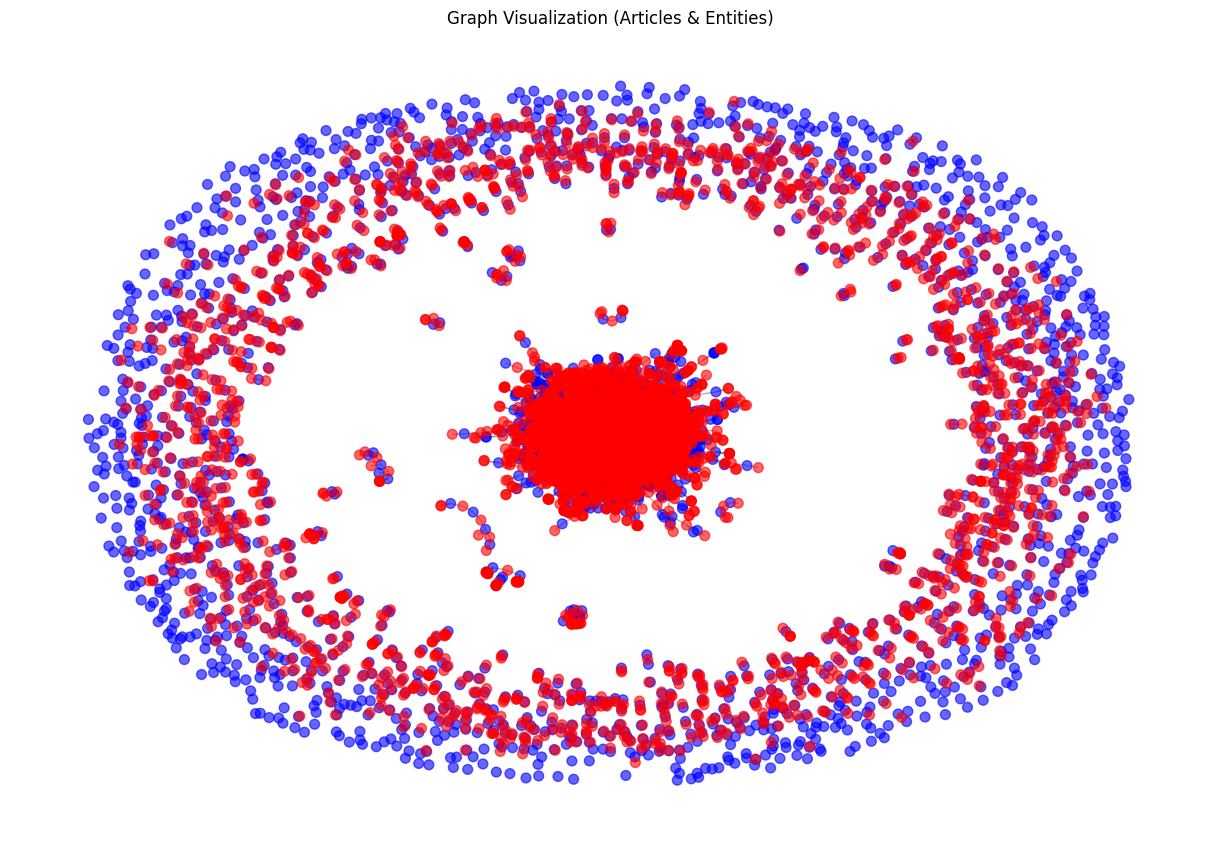

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Convert PyG graph to NetworkX format
G = to_networkx(graph_data, to_undirected=True)

# Assign colors: Articles (Blue), Entities (Red)
node_colors = ["blue" if i < len(data) else "red" for i in range(graph_data.num_nodes)]

# Set figure size
plt.figure(figsize=(12, 8))

# Draw the graph with node colors
pos = nx.spring_layout(G, seed=42)  # Spring layout for better visualization
nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=50, edge_color="gray", alpha=0.6)

# Show the graph
plt.title("Graph Visualization (Articles & Entities)")
plt.show()

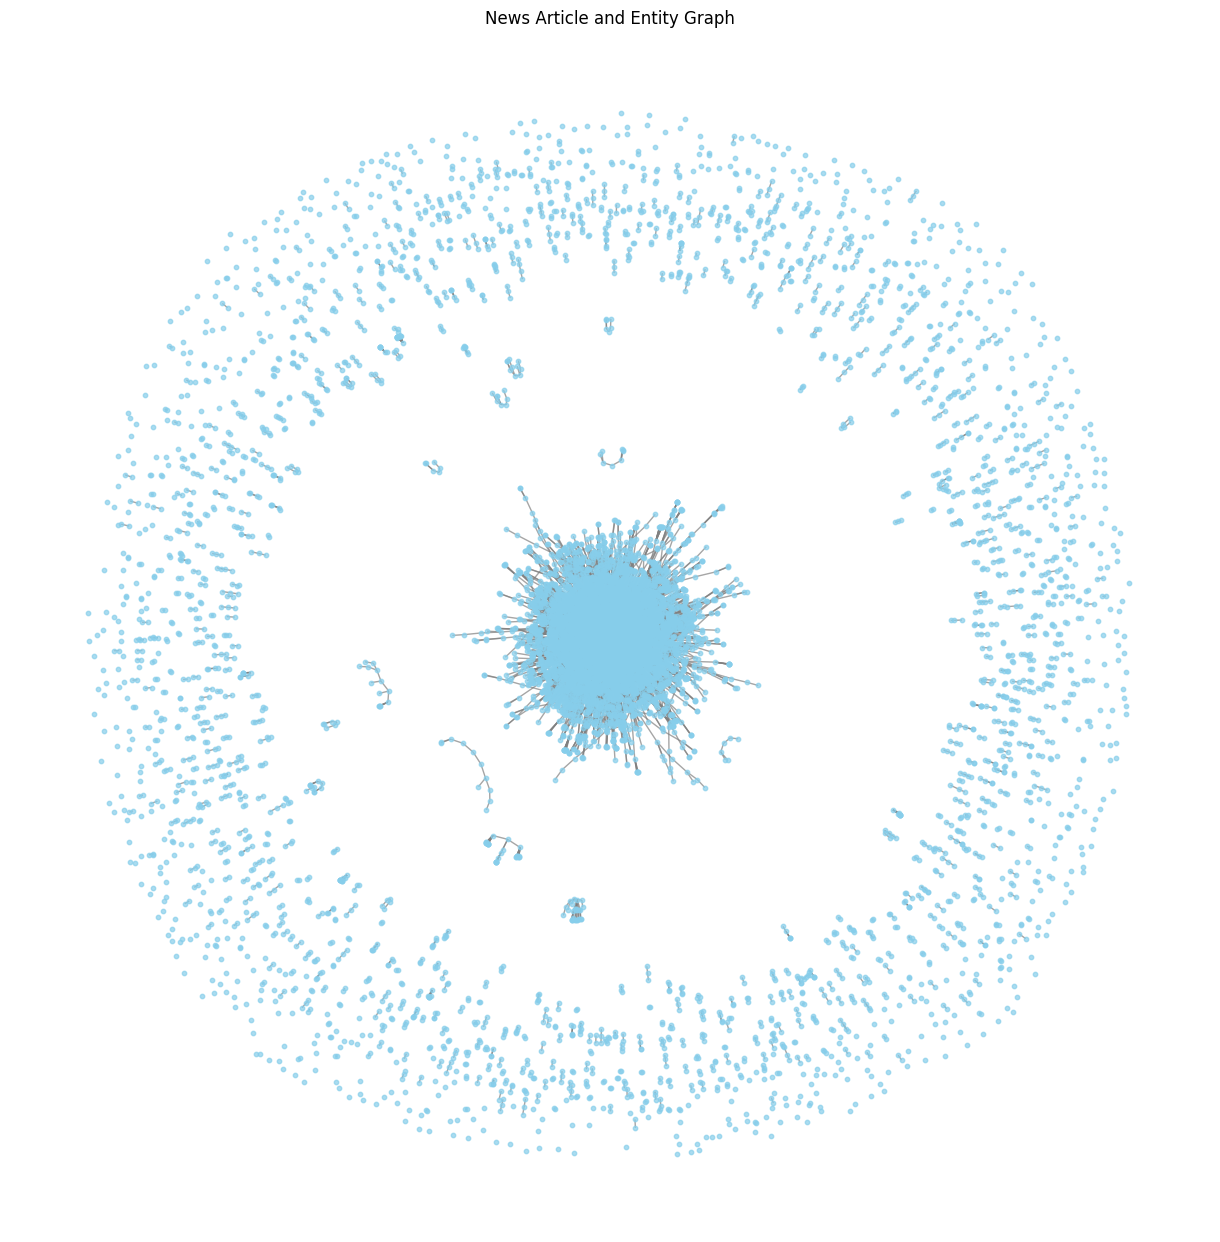

In [ ]:
# prompt: Visualize the Graph:


# Assuming 'graph_data' is your PyTorch Geometric Data object
# Extract the necessary information
edge_index = graph_data.edge_index.numpy()
num_nodes = graph_data.num_nodes

# Create a NetworkX graph
G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edge_index.T)

# Visualize the graph
plt.figure(figsize=(12, 12))  # Adjust figure size for better visualization
pos = nx.spring_layout(G, seed=42)  # Use a layout algorithm (e.g., spring_layout)
nx.draw(G, pos, with_labels=False, node_size=10, node_color="skyblue", edge_color="gray", alpha=0.7)
plt.title("News Article and Entity Graph")
plt.show()

In [ ]:
# Number of Nodes & Edges
num_nodes = graph_data.num_nodes
num_edges = graph_data.num_edges

# Number of Unique Labels (Bias Categories)
num_labels = len(torch.unique(graph_data.y))

# Print Statistics
print(f"📌 Number of Nodes: {num_nodes}")
print(f"📌 Number of Edges: {num_edges}")
print(f"📌 Number of Unique Labels: {num_labels}")

📌 Number of Nodes: 10801
📌 Number of Edges: 22836
📌 Number of Unique Labels: 3


In [ ]:
num_nodes = graph_data.num_nodes
# Initialize a dense adjacency matrix with zeros
adj_matrix = torch.zeros((num_nodes, num_nodes), dtype=torch.float)

# Fill the adjacency matrix using edge_index
adj_matrix[graph_data.edge_index[0], graph_data.edge_index[1]] = 1

print(adj_matrix)


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [ ]:
print(data[["text", "entities"]].head())


                                                text  \
0           RT Trey Radel FL slam Obamacare politics   
1         video Obamacare high Costs broken Promises   
2  join today remember fall hero honor man woman ...   
3  RT step Senate debate Leahy Crapo VAWA bill pr...   
4  delivery drone need update law promote innovat...   

                                entities  
0                        [Trey Radel FL]  
1                            [Obamacare]  
2                                [today]  
3     [today, Crapo VAWA, Leahy, Senate]  
4  [delivery drone need update law, UAS]  


In [ ]:
print("Number of edges:", len(edge_set))


Number of edges: 22836


In [ ]:
num_nodes = graph_data.num_nodes
adj_matrix = torch.zeros((num_nodes, num_nodes), dtype=torch.float)
adj_matrix[graph_data.edge_index[0], graph_data.edge_index[1]] = 1

# Count nonzero entries in the adjacency matrix
nonzero_count = (adj_matrix != 0).sum().item()
print("Number of non-zero entries in the adjacency matrix:", nonzero_count)

# Optionally, print indices of nonzero entries
nonzero_indices = torch.nonzero(adj_matrix)
print("Indices of nonzero entries:", nonzero_indices[:10])  # Print first 10 for brevity


Number of non-zero entries in the adjacency matrix: 22836
Indices of nonzero entries: tensor([[    0,  8407],
        [    1, 10490],
        [    2, 10296],
        [    3,  7963],
        [    3,  8237],
        [    3, 10296],
        [    3, 10441],
        [    4,  5415],
        [    4, 10575],
        [    5,  6648]])


# GCNConv Model


Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.01, weight_decay=0.0005
Validation metrics: Loss=0.4543, Acc=0.8280, F1=0.8073

Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.01, weight_decay=0.001
Validation metrics: Loss=0.6907, Acc=0.7987, F1=0.7211

Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.005, weight_decay=0.0005
Validation metrics: Loss=0.4353, Acc=0.8107, F1=0.7827

Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.005, weight_decay=0.001
Validation metrics: Loss=0.4704, Acc=0.8147, F1=0.7868

Testing hyperparameters: hidden_dim=32, dropout=0.5, lr=0.01, weight_decay=0.0005
Validation metrics: Loss=0.5161, Acc=0.8187, F1=0.7765

Testing hyperparameters: hidden_dim=32, dropout=0.5, lr=0.01, weight_decay=0.001
Validation metrics: Loss=0.4501, Acc=0.8267, F1=0.8029

Testing hyperparameters: hidden_dim=32, dropout=0.5, lr=0.005, weight_decay=0.0005
Validation metrics: Loss=0.5387, Acc=0.7080, F1=0.7325

Testing hyperparameters: hidden_d

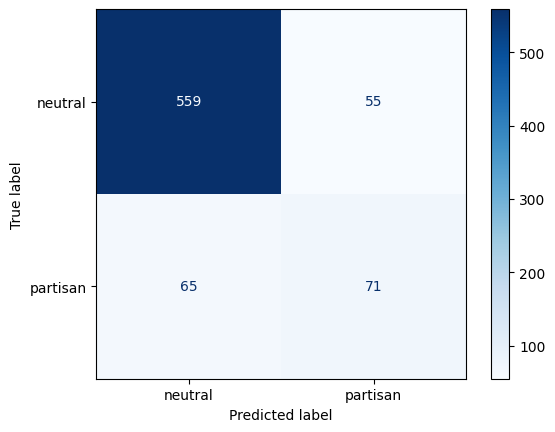


=== Test Results ===
Accuracy: 0.8400
Precision: 0.8356
Recall: 0.8400
F1 Score: 0.8376

Final test metrics:
Accuracy: 0.8400
Precision: 0.8356
Recall: 0.8400
F1 Score: 0.8376

Final model saved as 'best_GCN_model.pth'


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from itertools import product

# -------------------------------
# 1. Define the GCN Model (GNN)
# -------------------------------
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x  # Returns raw logits

# -------------------------------
# 2. Training, Validation, and Testing Functions
# -------------------------------
def train_one_epoch(model, optimizer, criterion, graph_data, train_mask, num_articles):
    model.train()
    optimizer.zero_grad()
    out = model(graph_data.x, graph_data.edge_index)
    # Use only article nodes (assumed to be first num_articles)
    preds_train = out[:num_articles][train_mask]
    labels_train = graph_data.y[:num_articles][train_mask]
    loss = criterion(preds_train, labels_train)
    loss.backward()
    optimizer.step()
    return loss.item()

def validate(model, criterion, graph_data, val_mask, num_articles):
    model.eval()
    with torch.no_grad():
        out = model(graph_data.x, graph_data.edge_index)
        preds_val = out[:num_articles][val_mask]
        labels_val = graph_data.y[:num_articles][val_mask]
        loss_val = criterion(preds_val, labels_val).item()
        pred_labels = preds_val.argmax(dim=1)
        accuracy_val = accuracy_score(labels_val.cpu(), pred_labels.cpu())
        precision_val, recall_val, f1_val, _ = precision_recall_fscore_support(
            labels_val.cpu(), pred_labels.cpu(), average='weighted', zero_division=0
        )
    return loss_val, accuracy_val, precision_val, recall_val, f1_val

def test(model, graph_data, test_mask, num_articles, label_encoder, criterion):
    model.eval()
    with torch.no_grad():
        out = model(graph_data.x, graph_data.edge_index)
        preds = out.argmax(dim=1)
        pred_articles = preds[:num_articles][test_mask]
        true_labels = graph_data.y[:num_articles][test_mask]
        accuracy = accuracy_score(true_labels.cpu(), pred_articles.cpu())
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels.cpu(), pred_articles.cpu(), average='weighted', zero_division=0
        )
        # Compute and display the confusion matrix
        cm = confusion_matrix(true_labels.cpu(), pred_articles.cpu())
        print("\n=== Confusion Matrix ===")
        print(cm)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
        print("\n=== Test Results ===")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
    return accuracy, precision, recall, f1

# -------------------------------
# 3. Hyperparameter Grid Search Function
# -------------------------------
def hyperparameter_search(graph_data, num_articles, train_mask, val_mask, input_dim, output_dim, device, epochs=50):
    param_grid = {
        'hidden_dim': [32, 64],
        'dropout': [0.3, 0.5],
        'lr': [0.01, 0.005],
        'weight_decay': [5e-4, 1e-3]
    }

    best_val_f1 = 0.0
    best_params = None
    best_model_state = None

    for hidden_dim, dropout, lr, weight_decay in product(param_grid['hidden_dim'],
                                                         param_grid['dropout'],
                                                         param_grid['lr'],
                                                         param_grid['weight_decay']):
        print(f"\nTesting hyperparameters: hidden_dim={hidden_dim}, dropout={dropout}, lr={lr}, weight_decay={weight_decay}")
        model = GNN(input_dim, hidden_dim, output_dim, dropout=dropout).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss()

        # Train for a fixed number of epochs
        for epoch in range(epochs):
            loss = train_one_epoch(model, optimizer, criterion, graph_data, train_mask, num_articles)

        # Validate the model
        val_loss, val_acc, val_prec, val_rec, val_f1 = validate(model, criterion, graph_data, val_mask, num_articles)
        print(f"Validation metrics: Loss={val_loss:.4f}, Acc={val_acc:.4f}, F1={val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_params = {'hidden_dim': hidden_dim, 'dropout': dropout, 'lr': lr, 'weight_decay': weight_decay}
            best_model_state = model.state_dict()

    print("\n=== Best Hyperparameters ===")
    print(best_params)
    print("Best Validation F1:", best_val_f1)
    return best_params, best_model_state

# -------------------------------
# 4. Main Pipeline
# -------------------------------
def main():
    # Ensure that the following variables are defined from your previous code:
    # - graph_data: PyG Data object with .x, .edge_index, .y, .train_mask, .val_mask, .test_mask.
    # - label_encoder: fitted LabelEncoder for your labels.
    # - num_articles: number of article nodes (first num_articles in graph_data.x and graph_data.y).

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define masks for article nodes
    train_mask_local = graph_data.train_mask[:num_articles]
    val_mask_local = graph_data.val_mask[:num_articles]
    test_mask_local = graph_data.test_mask[:num_articles]

    input_dim = graph_data.x.shape[1]
    output_dim = len(label_encoder.classes_)

    # Perform hyperparameter grid search
    best_params, best_model_state = hyperparameter_search(
        graph_data=graph_data,
        num_articles=num_articles,
        train_mask=train_mask_local,
        val_mask=val_mask_local,
        input_dim=input_dim,
        output_dim=output_dim,
        device=device,
        epochs=50
    )

    # Initialize the best model and load its state
    best_model = GNN(input_dim, best_params['hidden_dim'], output_dim, dropout=best_params['dropout']).to(device)
    best_model.load_state_dict(best_model_state)

    # Set up loss criterion
    criterion = nn.CrossEntropyLoss()

    # Evaluate on the test set
    test_accuracy, test_precision, test_recall, test_f1 = test(
        best_model, graph_data, test_mask_local, num_articles, label_encoder, criterion
    )

    print("\nFinal test metrics:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1 Score: {test_f1:.4f}")

    # Save the best model
    torch.save(best_model.state_dict(), "best_GCN_model.pth")
    print("\nFinal model saved as 'best_GCN_model.pth'")

if __name__ == '__main__':
    main()


# GraphSAGE Model


Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.01, weight_decay=0.0005
Validation metrics: Loss=0.4352, Acc=0.8120, F1=0.8143

Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.01, weight_decay=0.001
Validation metrics: Loss=0.4320, Acc=0.8160, F1=0.8101

Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.005, weight_decay=0.0005
Validation metrics: Loss=0.4291, Acc=0.8093, F1=0.8067

Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.005, weight_decay=0.001
Validation metrics: Loss=0.4285, Acc=0.8120, F1=0.8113

Testing hyperparameters: hidden_dim=32, dropout=0.5, lr=0.01, weight_decay=0.0005
Validation metrics: Loss=0.4278, Acc=0.8213, F1=0.8145

Testing hyperparameters: hidden_dim=32, dropout=0.5, lr=0.01, weight_decay=0.001
Validation metrics: Loss=0.4251, Acc=0.8280, F1=0.8159

Testing hyperparameters: hidden_dim=32, dropout=0.5, lr=0.005, weight_decay=0.0005
Validation metrics: Loss=0.4242, Acc=0.8160, F1=0.8066

Testing hyperparameters: hidden_d

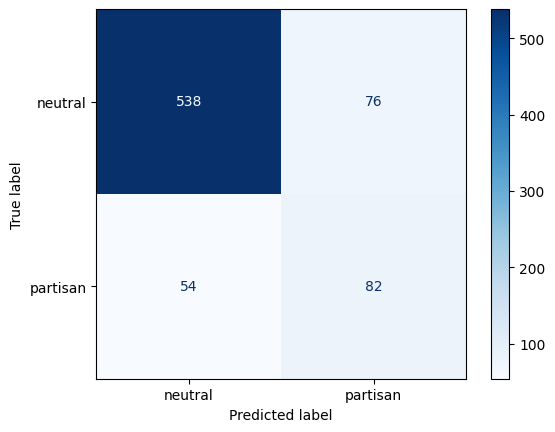


=== Test Results ===
Accuracy: 0.8267
Precision: 0.8381
Recall: 0.8267
F1 Score: 0.8316

Final test metrics:
Accuracy: 0.8267
Precision: 0.8381
Recall: 0.8267
F1 Score: 0.8316

Final model saved as 'best_GraphSAGE_model.pth'


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv  # Using GraphSAGE convolution
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from itertools import product

# -------------------------------
# 1. Define the GraphSAGE Model
# -------------------------------
class GraphSAGEModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x  # Returns raw logits

# -------------------------------
# 2. Training, Validation, and Testing Functions
# -------------------------------
def train_one_epoch(model, optimizer, criterion, graph_data, train_mask, num_articles):
    model.train()
    optimizer.zero_grad()
    out = model(graph_data.x, graph_data.edge_index)
    # Use only article nodes (assumed to be the first num_articles nodes)
    preds_train = out[:num_articles][train_mask]
    labels_train = graph_data.y[:num_articles][train_mask]
    loss = criterion(preds_train, labels_train)
    loss.backward()
    optimizer.step()
    return loss.item()

def validate(model, criterion, graph_data, val_mask, num_articles):
    model.eval()
    with torch.no_grad():
        out = model(graph_data.x, graph_data.edge_index)
        preds_val = out[:num_articles][val_mask]
        labels_val = graph_data.y[:num_articles][val_mask]
        loss_val = criterion(preds_val, labels_val).item()
        pred_labels = preds_val.argmax(dim=1)
        accuracy_val = accuracy_score(labels_val.cpu(), pred_labels.cpu())
        precision_val, recall_val, f1_val, _ = precision_recall_fscore_support(
            labels_val.cpu(), pred_labels.cpu(), average='weighted', zero_division=0
        )
    return loss_val, accuracy_val, precision_val, recall_val, f1_val

def test(model, graph_data, test_mask, num_articles, label_encoder, criterion):
    model.eval()
    with torch.no_grad():
        out = model(graph_data.x, graph_data.edge_index)
        preds = out.argmax(dim=1)
        pred_articles = preds[:num_articles][test_mask]
        true_labels = graph_data.y[:num_articles][test_mask]
        accuracy = accuracy_score(true_labels.cpu(), pred_articles.cpu())
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels.cpu(), pred_articles.cpu(), average='weighted', zero_division=0
        )
        # Compute and display the confusion matrix
        cm = confusion_matrix(true_labels.cpu(), pred_articles.cpu())
        print("\n=== Confusion Matrix ===")
        print(cm)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
        print("\n=== Test Results ===")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
    return accuracy, precision, recall, f1

# -------------------------------
# 3. Hyperparameter Grid Search Function
# -------------------------------
def hyperparameter_search(graph_data, num_articles, train_mask, val_mask, input_dim, output_dim, device, epochs=50):
    param_grid = {
        'hidden_dim': [32, 64],
        'dropout': [0.3, 0.5],
        'lr': [0.01, 0.005],
        'weight_decay': [5e-4, 1e-3]
    }

    best_val_f1 = 0.0
    best_params = None
    best_model_state = None

    for hidden_dim, dropout, lr, weight_decay in product(param_grid['hidden_dim'],
                                                         param_grid['dropout'],
                                                         param_grid['lr'],
                                                         param_grid['weight_decay']):
        print(f"\nTesting hyperparameters: hidden_dim={hidden_dim}, dropout={dropout}, lr={lr}, weight_decay={weight_decay}")
        model = GraphSAGEModel(input_dim, hidden_dim, output_dim, dropout=dropout).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss()

        # Train for a fixed number of epochs
        for epoch in range(epochs):
            loss = train_one_epoch(model, optimizer, criterion, graph_data, train_mask, num_articles)

        # Validate the model
        val_loss, val_acc, val_prec, val_rec, val_f1 = validate(model, criterion, graph_data, val_mask, num_articles)
        print(f"Validation metrics: Loss={val_loss:.4f}, Acc={val_acc:.4f}, F1={val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_params = {'hidden_dim': hidden_dim, 'dropout': dropout, 'lr': lr, 'weight_decay': weight_decay}
            best_model_state = model.state_dict()

    print("\n=== Best Hyperparameters ===")
    print(best_params)
    print("Best Validation F1:", best_val_f1)
    return best_params, best_model_state

# -------------------------------
# 4. Main Pipeline
# -------------------------------
def main():
    # Ensure that the following variables are defined from your previous code:
    # - graph_data: PyG Data object with .x, .edge_index, .y, .train_mask, .val_mask, .test_mask.
    # - label_encoder: fitted LabelEncoder for your labels.
    # - num_articles: number of article nodes (first num_articles in graph_data.x and graph_data.y).

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define masks for article nodes
    train_mask_local = graph_data.train_mask[:num_articles]
    val_mask_local = graph_data.val_mask[:num_articles]
    test_mask_local = graph_data.test_mask[:num_articles]

    input_dim = graph_data.x.shape[1]
    output_dim = len(label_encoder.classes_)

    # Perform hyperparameter grid search
    best_params, best_model_state = hyperparameter_search(
        graph_data=graph_data,
        num_articles=num_articles,
        train_mask=train_mask_local,
        val_mask=val_mask_local,
        input_dim=input_dim,
        output_dim=output_dim,
        device=device,
        epochs=50
    )

    # Initialize the best model and load its state
    best_model = GraphSAGEModel(input_dim, best_params['hidden_dim'], output_dim, dropout=best_params['dropout']).to(device)
    best_model.load_state_dict(best_model_state)

    # Set up loss criterion
    criterion = nn.CrossEntropyLoss()

    # Evaluate on the test set
    test_accuracy, test_precision, test_recall, test_f1 = test(
        best_model, graph_data, test_mask_local, num_articles, label_encoder, criterion
    )

    print("\nFinal test metrics:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1 Score: {test_f1:.4f}")

    # Save the best model
    torch.save(best_model.state_dict(), "best_GraphSAGE_model.pth")
    print("\nFinal model saved as 'best_GraphSAGE_model.pth'")

if __name__ == '__main__':
    main()


# GAT Model


Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.01, weight_decay=0.0005, heads=4
Validation metrics: Loss=0.4554, Acc=0.8067, F1=0.7971

Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.01, weight_decay=0.0005, heads=8
Validation metrics: Loss=0.4795, Acc=0.7880, F1=0.7877

Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.01, weight_decay=0.001, heads=4
Validation metrics: Loss=0.4343, Acc=0.8147, F1=0.7682

Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.01, weight_decay=0.001, heads=8
Validation metrics: Loss=0.5744, Acc=0.7080, F1=0.7336

Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.005, weight_decay=0.0005, heads=4
Validation metrics: Loss=0.4287, Acc=0.8227, F1=0.7941

Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.005, weight_decay=0.0005, heads=8
Validation metrics: Loss=0.4370, Acc=0.8187, F1=0.8035

Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.005, weight_decay=0.001, heads=4
Validation metrics: Loss=0

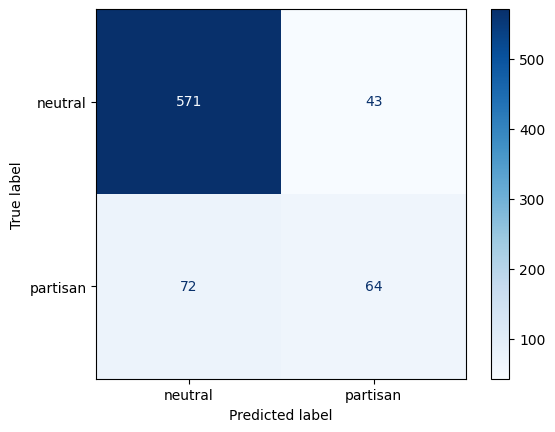


=== Test Results ===
Accuracy: 0.8467
Precision: 0.8355
Recall: 0.8467
F1 Score: 0.8393

Final test metrics:
Accuracy: 0.8467
Precision: 0.8355
Recall: 0.8467
F1 Score: 0.8393

Final model saved as 'best_GAT_model.pth'


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from itertools import product

# -------------------------------
# 1. Define the GAT Model
# -------------------------------
class GATModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5, heads=8):
        super(GATModel, self).__init__()
        # First GAT layer with multi-head attention (concat=True)
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, dropout=dropout, concat=True)
        # Batch normalization applied on the concatenated output (hidden_dim * heads)
        self.bn1 = nn.BatchNorm1d(hidden_dim * heads)
        # Second GAT layer with a single head and no concatenation
        self.gat2 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = self.bn1(x)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.gat2(x, edge_index)
        return x  # Raw logits

# -------------------------------
# 2. Training, Validation, and Testing Functions
# -------------------------------
def train_one_epoch(model, optimizer, criterion, graph_data, train_mask, num_articles):
    model.train()
    optimizer.zero_grad()
    out = model(graph_data.x, graph_data.edge_index)
    # Use only the article nodes (assumed to be the first num_articles nodes)
    preds_train = out[:num_articles][train_mask]
    labels_train = graph_data.y[:num_articles][train_mask]
    loss = criterion(preds_train, labels_train)
    loss.backward()
    optimizer.step()
    return loss.item()

def validate(model, criterion, graph_data, val_mask, num_articles):
    model.eval()
    with torch.no_grad():
        out = model(graph_data.x, graph_data.edge_index)
        preds_val = out[:num_articles][val_mask]
        labels_val = graph_data.y[:num_articles][val_mask]
        loss_val = criterion(preds_val, labels_val).item()
        pred_labels = preds_val.argmax(dim=1)
        accuracy_val = accuracy_score(labels_val.cpu(), pred_labels.cpu())
        precision_val, recall_val, f1_val, _ = precision_recall_fscore_support(
            labels_val.cpu(), pred_labels.cpu(), average='weighted', zero_division=0
        )
    return loss_val, accuracy_val, precision_val, recall_val, f1_val

def test(model, graph_data, test_mask, num_articles, label_encoder, criterion):
    model.eval()
    with torch.no_grad():
        out = model(graph_data.x, graph_data.edge_index)
        preds = out.argmax(dim=1)
        pred_articles = preds[:num_articles][test_mask]
        true_labels = graph_data.y[:num_articles][test_mask]
        accuracy = accuracy_score(true_labels.cpu(), pred_articles.cpu())
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels.cpu(), pred_articles.cpu(), average='weighted', zero_division=0
        )
        # Compute and display the confusion matrix
        cm = confusion_matrix(true_labels.cpu(), pred_articles.cpu())
        print("\n=== Confusion Matrix ===")
        print(cm)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
        print("\n=== Test Results ===")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
    return accuracy, precision, recall, f1

# -------------------------------
# 3. Hyperparameter Grid Search Function
# -------------------------------
def hyperparameter_search(graph_data, num_articles, train_mask, val_mask, input_dim, output_dim, device, epochs=50):
    # Define a grid for hyperparameters, including number of attention heads
    param_grid = {
        'hidden_dim': [32, 64],
        'dropout': [0.3, 0.5],
        'lr': [0.01, 0.005],
        'weight_decay': [5e-4, 1e-3],
        'heads': [4, 8]
    }

    best_val_f1 = 0.0
    best_params = None
    best_model_state = None

    for hidden_dim, dropout, lr, weight_decay, heads in product(
            param_grid['hidden_dim'],
            param_grid['dropout'],
            param_grid['lr'],
            param_grid['weight_decay'],
            param_grid['heads']):

        print(f"\nTesting hyperparameters: hidden_dim={hidden_dim}, dropout={dropout}, lr={lr}, weight_decay={weight_decay}, heads={heads}")
        model = GATModel(input_dim, hidden_dim, output_dim, dropout=dropout, heads=heads).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss()

        # Train for a fixed number of epochs
        for epoch in range(epochs):
            loss = train_one_epoch(model, optimizer, criterion, graph_data, train_mask, num_articles)
            # Optionally, you can print per-epoch loss if desired:
            # print(f"Epoch {epoch+1}/{epochs} Loss: {loss:.4f}")

        # Validate the model
        val_loss, val_acc, val_prec, val_rec, val_f1 = validate(model, criterion, graph_data, val_mask, num_articles)
        print(f"Validation metrics: Loss={val_loss:.4f}, Acc={val_acc:.4f}, F1={val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_params = {
                'hidden_dim': hidden_dim,
                'dropout': dropout,
                'lr': lr,
                'weight_decay': weight_decay,
                'heads': heads
            }
            best_model_state = model.state_dict()

    print("\n=== Best Hyperparameters ===")
    print(best_params)
    print("Best Validation F1:", best_val_f1)
    return best_params, best_model_state

# -------------------------------
# 4. Main Pipeline
# -------------------------------
def main():
    # Ensure that the following variables are defined from your previous code:
    # - graph_data: PyG Data object with .x, .edge_index, .y, .train_mask, .val_mask, .test_mask.
    # - label_encoder: Fitted LabelEncoder for your labels.
    # - num_articles: Number of article nodes (first num_articles in graph_data.x and graph_data.y).

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define masks for article nodes (first num_articles nodes)
    train_mask_local = graph_data.train_mask[:num_articles]
    val_mask_local = graph_data.val_mask[:num_articles]
    test_mask_local = graph_data.test_mask[:num_articles]

    input_dim = graph_data.x.shape[1]
    output_dim = len(label_encoder.classes_)

    # Perform hyperparameter grid search
    best_params, best_model_state = hyperparameter_search(
        graph_data=graph_data,
        num_articles=num_articles,
        train_mask=train_mask_local,
        val_mask=val_mask_local,
        input_dim=input_dim,
        output_dim=output_dim,
        device=device,
        epochs=50
    )

    # Initialize the best model and load its state
    best_model = GATModel(input_dim, best_params['hidden_dim'], output_dim, dropout=best_params['dropout'], heads=best_params['heads']).to(device)
    best_model.load_state_dict(best_model_state)

    # Set up loss criterion
    criterion = nn.CrossEntropyLoss()

    # Evaluate on the test set
    test_accuracy, test_precision, test_recall, test_f1 = test(
        best_model, graph_data, test_mask_local, num_articles, label_encoder, criterion
    )

    print("\nFinal test metrics:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1 Score: {test_f1:.4f}")

    # Save the best model
    torch.save(best_model.state_dict(), "best_GAT_model.pth")
    print("\nFinal model saved as 'best_GAT_model.pth'")

if __name__ == '__main__':
    main()


# Gated-GNN Model


Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.01, weight_decay=0.0005, num_layers=2
Validation metrics: Loss=0.4162, Acc=0.8360, F1=0.8262

Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.01, weight_decay=0.0005, num_layers=3
Validation metrics: Loss=0.4244, Acc=0.8200, F1=0.8150

Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.01, weight_decay=0.001, num_layers=2
Validation metrics: Loss=0.4241, Acc=0.8147, F1=0.8106

Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.01, weight_decay=0.001, num_layers=3
Validation metrics: Loss=0.4393, Acc=0.7947, F1=0.7979

Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.005, weight_decay=0.0005, num_layers=2
Validation metrics: Loss=0.4294, Acc=0.8120, F1=0.8131

Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.005, weight_decay=0.0005, num_layers=3
Validation metrics: Loss=0.4209, Acc=0.8307, F1=0.8212

Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.005, weight_decay=0.001, num_

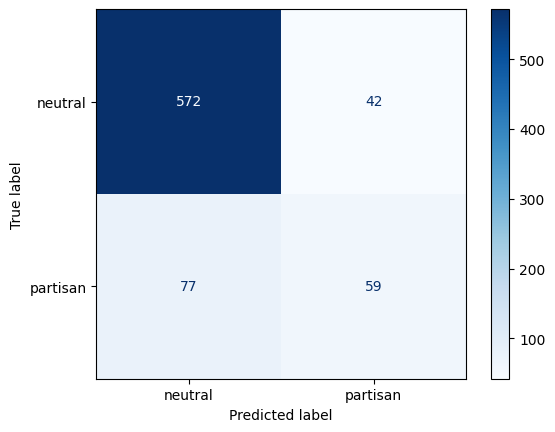


=== Test Results ===
Accuracy: 0.8413
Precision: 0.8275
Recall: 0.8413
F1 Score: 0.8318

Final test metrics:
Accuracy: 0.8413
Precision: 0.8275
Recall: 0.8413
F1 Score: 0.8318

Final model saved as 'best_GatedGNN_model.pth'


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GatedGraphConv
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from itertools import product

# -------------------------------
# 1. Define the Gated-GNN Model
# -------------------------------
class GatedGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout=0.5):
        super(GatedGNN, self).__init__()
        # Project input features to hidden_dim if needed.
        self.lin_in = nn.Linear(input_dim, hidden_dim)
        # GatedGraphConv: performs message passing for num_layers steps.
        self.ggnn = GatedGraphConv(out_channels=hidden_dim, num_layers=num_layers, aggr='add')
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.lin_in(x)
        x = self.ggnn(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x  # Returns raw logits

# -------------------------------
# 2. Training, Validation, and Testing Functions
# -------------------------------
def train_one_epoch(model, optimizer, criterion, graph_data, train_mask, num_articles):
    model.train()
    optimizer.zero_grad()
    out = model(graph_data.x, graph_data.edge_index)
    # Use only article nodes (assumed to be the first num_articles nodes)
    preds_train = out[:num_articles][train_mask]
    labels_train = graph_data.y[:num_articles][train_mask]
    loss = criterion(preds_train, labels_train)
    loss.backward()
    optimizer.step()
    return loss.item()

def validate(model, criterion, graph_data, val_mask, num_articles):
    model.eval()
    with torch.no_grad():
        out = model(graph_data.x, graph_data.edge_index)
        preds_val = out[:num_articles][val_mask]
        labels_val = graph_data.y[:num_articles][val_mask]
        loss_val = criterion(preds_val, labels_val).item()
        pred_labels = preds_val.argmax(dim=1)
        accuracy_val = accuracy_score(labels_val.cpu(), pred_labels.cpu())
        precision_val, recall_val, f1_val, _ = precision_recall_fscore_support(
            labels_val.cpu(), pred_labels.cpu(), average='weighted', zero_division=0
        )
    return loss_val, accuracy_val, precision_val, recall_val, f1_val

def test(model, graph_data, test_mask, num_articles, label_encoder, criterion):
    model.eval()
    with torch.no_grad():
        out = model(graph_data.x, graph_data.edge_index)
        preds = out.argmax(dim=1)
        pred_articles = preds[:num_articles][test_mask]
        true_labels = graph_data.y[:num_articles][test_mask]
        accuracy = accuracy_score(true_labels.cpu(), pred_articles.cpu())
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels.cpu(), pred_articles.cpu(), average='weighted', zero_division=0
        )
        # Compute and display the confusion matrix
        cm = confusion_matrix(true_labels.cpu(), pred_articles.cpu())
        print("\n=== Confusion Matrix ===")
        print(cm)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
        print("\n=== Test Results ===")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
    return accuracy, precision, recall, f1

# -------------------------------
# 3. Hyperparameter Grid Search Function
# -------------------------------
def hyperparameter_search(graph_data, num_articles, train_mask, val_mask, input_dim, output_dim, device, epochs=50):
    param_grid = {
        'hidden_dim': [32, 64],
        'dropout': [0.3, 0.5],
        'lr': [0.01, 0.005],
        'weight_decay': [5e-4, 1e-3],
        'num_layers': [2, 3]
    }

    best_val_f1 = 0.0
    best_params = None
    best_model_state = None

    for hidden_dim, dropout, lr, weight_decay, num_layers in product(
            param_grid['hidden_dim'],
            param_grid['dropout'],
            param_grid['lr'],
            param_grid['weight_decay'],
            param_grid['num_layers']):

        print(f"\nTesting hyperparameters: hidden_dim={hidden_dim}, dropout={dropout}, lr={lr}, weight_decay={weight_decay}, num_layers={num_layers}")
        model = GatedGNN(input_dim, hidden_dim, output_dim, num_layers=num_layers, dropout=dropout).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss()

        # Train for a fixed number of epochs
        for epoch in range(epochs):
            loss = train_one_epoch(model, optimizer, criterion, graph_data, train_mask, num_articles)
            # (Optional) print per-epoch loss if desired

        # Validate the model
        val_loss, val_acc, val_prec, val_rec, val_f1 = validate(model, criterion, graph_data, val_mask, num_articles)
        print(f"Validation metrics: Loss={val_loss:.4f}, Acc={val_acc:.4f}, F1={val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_params = {
                'hidden_dim': hidden_dim,
                'dropout': dropout,
                'lr': lr,
                'weight_decay': weight_decay,
                'num_layers': num_layers
            }
            best_model_state = model.state_dict()

    print("\n=== Best Hyperparameters ===")
    print(best_params)
    print("Best Validation F1:", best_val_f1)
    return best_params, best_model_state

# -------------------------------
# 4. Main Pipeline
# -------------------------------
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Make sure these variables are defined from your previous code:
    # - graph_data: PyG Data object with .x, .edge_index, .y, .train_mask, .val_mask, .test_mask.
    # - label_encoder: Fitted LabelEncoder for your labels.
    # - num_articles: Number of article nodes (first num_articles nodes in graph_data.x and graph_data.y).

    # Define masks for article nodes (assuming the first num_articles nodes correspond to articles)
    train_mask_local = graph_data.train_mask[:num_articles]
    val_mask_local = graph_data.val_mask[:num_articles]
    test_mask_local = graph_data.test_mask[:num_articles]

    input_dim = graph_data.x.shape[1]
    output_dim = len(label_encoder.classes_)

    # Perform hyperparameter grid search on the validation set
    best_params, best_model_state = hyperparameter_search(
        graph_data=graph_data,
        num_articles=num_articles,
        train_mask=train_mask_local,
        val_mask=val_mask_local,
        input_dim=input_dim,
        output_dim=output_dim,
        device=device,
        epochs=50
    )

    # Initialize the best model using the best hyperparameters and load its state
    best_model = GatedGNN(input_dim, best_params['hidden_dim'], output_dim, num_layers=best_params['num_layers'], dropout=best_params['dropout']).to(device)
    best_model.load_state_dict(best_model_state)

    # Set up loss criterion
    criterion = nn.CrossEntropyLoss()

    # Evaluate on the test set
    test_accuracy, test_precision, test_recall, test_f1 = test(
        best_model, graph_data, test_mask_local, num_articles, label_encoder, criterion
    )

    print("\nFinal test metrics:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1 Score: {test_f1:.4f}")

    # Save the best model
    torch.save(best_model.state_dict(), "best_GatedGNN_model.pth")
    print("\nFinal model saved as 'best_GatedGNN_model.pth'")

if __name__ == '__main__':
    main()


# GIN Model


Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.01, weight_decay=0.0005, num_layers=2
Validation metrics: Loss=0.5210, Acc=0.7933, F1=0.7019

Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.01, weight_decay=0.0005, num_layers=3
Validation metrics: Loss=0.5136, Acc=0.7933, F1=0.7019

Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.01, weight_decay=0.001, num_layers=2
Validation metrics: Loss=0.5003, Acc=0.7933, F1=0.7019

Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.01, weight_decay=0.001, num_layers=3
Validation metrics: Loss=0.4904, Acc=0.7933, F1=0.7019

Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.005, weight_decay=0.0005, num_layers=2
Validation metrics: Loss=0.5808, Acc=0.6893, F1=0.6952

Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.005, weight_decay=0.0005, num_layers=3
Validation metrics: Loss=0.5073, Acc=0.7933, F1=0.7019

Testing hyperparameters: hidden_dim=32, dropout=0.3, lr=0.005, weight_decay=0.001, num_

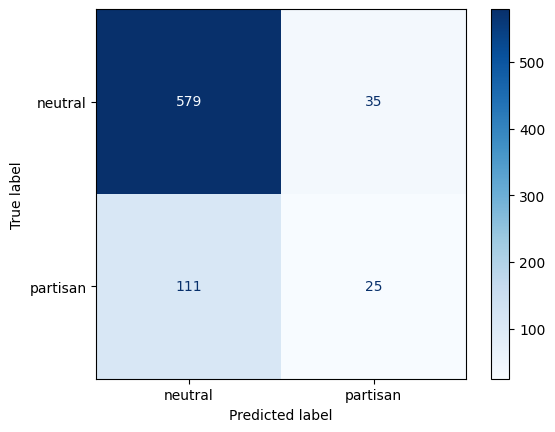


=== Test Results ===
Accuracy: 0.8053
Precision: 0.7625
Recall: 0.8053
F1 Score: 0.7733

Final test metrics:
Accuracy: 0.8053
Precision: 0.7625
Recall: 0.8053
F1 Score: 0.7733

Final model saved as 'best_GIN_model.pth'


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from itertools import product

# -------------------------------
# 1. Define the GIN Model
# -------------------------------
class GINModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout=0.5):
        """
        Initializes a GIN model.

        Args:
            input_dim (int): Dimensionality of input features.
            hidden_dim (int): Dimensionality of hidden representations.
            output_dim (int): Number of output classes.
            num_layers (int): Number of GINConv layers.
            dropout (float): Dropout rate.
        """
        super(GINModel, self).__init__()
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        # First GIN layer: projects input_dim to hidden_dim.
        mlp1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.convs.append(GINConv(mlp1))
        self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        # Additional GIN layers
        for _ in range(num_layers - 1):
            mlp = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            )
            self.convs.append(GINConv(mlp))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        # Final classification layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        # Pass through each GINConv layer
        for conv, bn in zip(self.convs, self.batch_norms):
            x = conv(x, edge_index)
            x = bn(x)
            x = F.relu(x)
            x = self.dropout(x)
        x = self.fc(x)
        return x  # Raw logits

# -------------------------------
# 2. Training, Validation, and Testing Functions
# -------------------------------
def train_one_epoch(model, optimizer, criterion, graph_data, train_mask, num_articles):
    model.train()
    optimizer.zero_grad()
    out = model(graph_data.x, graph_data.edge_index)
    # Use only the article nodes (assumed to be the first num_articles)
    preds_train = out[:num_articles][train_mask]
    labels_train = graph_data.y[:num_articles][train_mask]
    loss = criterion(preds_train, labels_train)
    loss.backward()
    optimizer.step()
    return loss.item()

def validate(model, criterion, graph_data, val_mask, num_articles):
    model.eval()
    with torch.no_grad():
        out = model(graph_data.x, graph_data.edge_index)
        preds_val = out[:num_articles][val_mask]
        labels_val = graph_data.y[:num_articles][val_mask]
        loss_val = criterion(preds_val, labels_val).item()
        pred_labels = preds_val.argmax(dim=1)
        accuracy_val = accuracy_score(labels_val.cpu(), pred_labels.cpu())
        precision_val, recall_val, f1_val, _ = precision_recall_fscore_support(
            labels_val.cpu(), pred_labels.cpu(), average='weighted', zero_division=0
        )
    return loss_val, accuracy_val, precision_val, recall_val, f1_val

def test(model, graph_data, test_mask, num_articles, label_encoder, criterion):
    model.eval()
    with torch.no_grad():
        out = model(graph_data.x, graph_data.edge_index)
        preds = out.argmax(dim=1)
        pred_articles = preds[:num_articles][test_mask]
        true_labels = graph_data.y[:num_articles][test_mask]
        accuracy = accuracy_score(true_labels.cpu(), pred_articles.cpu())
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels.cpu(), pred_articles.cpu(), average='weighted', zero_division=0
        )
        # Compute and display the confusion matrix
        cm = confusion_matrix(true_labels.cpu(), pred_articles.cpu())
        print("\n=== Confusion Matrix ===")
        print(cm)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
        print("\n=== Test Results ===")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
    return accuracy, precision, recall, f1

# -------------------------------
# 3. Hyperparameter Grid Search Function
# -------------------------------
def hyperparameter_search(graph_data, num_articles, train_mask, val_mask, input_dim, output_dim, device, epochs=50):
    param_grid = {
        'hidden_dim': [32, 64],
        'dropout': [0.3, 0.5],
        'lr': [0.01, 0.005],
        'weight_decay': [5e-4, 1e-3],
        'num_layers': [2, 3]
    }

    best_val_f1 = 0.0
    best_params = None
    best_model_state = None

    for hidden_dim, dropout, lr, weight_decay, num_layers in product(
            param_grid['hidden_dim'],
            param_grid['dropout'],
            param_grid['lr'],
            param_grid['weight_decay'],
            param_grid['num_layers']):

        print(f"\nTesting hyperparameters: hidden_dim={hidden_dim}, dropout={dropout}, lr={lr}, weight_decay={weight_decay}, num_layers={num_layers}")
        model = GINModel(input_dim, hidden_dim, output_dim, num_layers=num_layers, dropout=dropout).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss()

        # Train for a fixed number of epochs
        for epoch in range(epochs):
            loss = train_one_epoch(model, optimizer, criterion, graph_data, train_mask, num_articles)

        # Validate the model
        val_loss, val_acc, val_prec, val_rec, val_f1 = validate(model, criterion, graph_data, val_mask, num_articles)
        print(f"Validation metrics: Loss={val_loss:.4f}, Acc={val_acc:.4f}, F1={val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_params = {
                'hidden_dim': hidden_dim,
                'dropout': dropout,
                'lr': lr,
                'weight_decay': weight_decay,
                'num_layers': num_layers
            }
            best_model_state = model.state_dict()

    print("\n=== Best Hyperparameters ===")
    print(best_params)
    print("Best Validation F1:", best_val_f1)
    return best_params, best_model_state

# -------------------------------
# 4. Main Pipeline
# -------------------------------
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # These variables should be defined from your previous processing:
    #   graph_data: PyG Data object with .x, .edge_index, .y, .train_mask, .val_mask, .test_mask.
    #   label_encoder: Fitted LabelEncoder for your labels.
    #   num_articles: Number of article nodes (first num_articles nodes in graph_data.x and graph_data.y).
    train_mask_local = graph_data.train_mask[:num_articles]
    val_mask_local = graph_data.val_mask[:num_articles]
    test_mask_local = graph_data.test_mask[:num_articles]

    input_dim = graph_data.x.shape[1]
    output_dim = len(label_encoder.classes_)

    # Perform hyperparameter grid search on the validation set
    best_params, best_model_state = hyperparameter_search(
        graph_data=graph_data,
        num_articles=num_articles,
        train_mask=train_mask_local,
        val_mask=val_mask_local,
        input_dim=input_dim,
        output_dim=output_dim,
        device=device,
        epochs=50
    )

    # Initialize the best model using the best hyperparameters and load its state
    best_model = GINModel(input_dim, best_params['hidden_dim'], output_dim, num_layers=best_params['num_layers'], dropout=best_params['dropout']).to(device)
    best_model.load_state_dict(best_model_state)

    # Set up the loss criterion
    criterion = nn.CrossEntropyLoss()

    # Evaluate on the test set
    test_accuracy, test_precision, test_recall, test_f1 = test(
        best_model, graph_data, test_mask_local, num_articles, label_encoder, criterion
    )

    print("\nFinal test metrics:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1 Score: {test_f1:.4f}")

    # Save the best model
    torch.save(best_model.state_dict(), "best_GIN_model.pth")
    print("\nFinal model saved as 'best_GIN_model.pth'")

if __name__ == '__main__':
    main()
